In [24]:
from data_preprocessing import *
import math
from xgboost import XGBRegressor, DMatrix, plot_importance
from xgboost import cv as xgb_cv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,
)

In [2]:
# call XGBmodel
xgb_model = XGBRegressor(n_estimators=1000)

In [3]:
# this function make split datset to number of samples and train it one after the other 
def compute_learning_curves(model, X_train,X_val, y, y_val, curve_step, verbose=False):  
    
    # n_train_obs is number of rows
    n_train_obs = X_train.shape[0]
    
    # n_iter is number of iterations 
    n_iter = math.ceil(n_train_obs / curve_step)
    
    # define lists that contains erroes and steps numbers
    train_errors, val_errors, steps = [], [], []
    
    # loop for train and predict model in number of iterations
    for i in range(n_iter):
        
        # amounts data points 
        n_obs = (i+1) * curve_step
        n_obs = min(n_obs, n_train_obs)
        
        # training sample
        model.fit(X_train[:n_obs], y_train[:n_obs])
        
        # predicting training_sample
        y_train_predict = model.predict(X_train[:n_obs])
        
        # predicting testing_sample
        y_val_predict = model.predict(X_val)
        
        # calculating errors
        train_mse = mean_squared_error(y_train[:n_obs], y_train_predict)
        val_mse = mean_squared_error(y_val, y_val_predict)
        val_mse=val_mse  
        train_mse=train_mse 
        
        # appending train_mse, val_mse, n_obs on their lists
        train_errors.append(train_mse)
        val_errors.append(val_mse)
        steps.append(n_obs)
        
        # if you like show results during training
        if verbose:
            msg = "Iteration {0}/{1}: train_rmse={2:.2f}, val_rmse={3:.2f}".format(
                i+1, n_iter, np.sqrt(train_mse), np.sqrt(val_mse)
            )
            print(msg)
    return steps, train_errors, val_errors

# drawing the differnce between train_rmse and val_rmse
def plot_learning_curves(steps, train_errors, val_errors, ax=None, title=""):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 4))
    train_rmse = np.sqrt(train_errors)
    val_rmse = np.sqrt(val_errors)
    ax.plot(steps, train_rmse, color="tab:blue",
            marker=".", label="training")
    ax.plot(steps, val_rmse, color="tab:orange",
            marker=".", label="validation")
    ylim = (0.8*np.median(train_rmse),
            1.5*np.median(val_rmse))
    ax.set_ylim(ylim)
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("RMSE (MW)")
    ax.set_title(title)
    ax.legend()
    ax.grid()
    

In [4]:
# apply function compute_learning_curves
xgb_steps, xgb_train_mse, xgb_val_mse = compute_learning_curves(
    xgb_model,X_train_prep, X_test_prep, y_train, y_test,  500, verbose=True
)

Iteration 1/72: train_rmse=0.01, val_rmse=4161.35
Iteration 2/72: train_rmse=0.01, val_rmse=3779.84
Iteration 3/72: train_rmse=0.01, val_rmse=3660.50
Iteration 4/72: train_rmse=0.01, val_rmse=3423.06
Iteration 5/72: train_rmse=0.01, val_rmse=2616.00
Iteration 6/72: train_rmse=0.02, val_rmse=2490.16
Iteration 7/72: train_rmse=0.06, val_rmse=2345.50
Iteration 8/72: train_rmse=0.20, val_rmse=2222.99
Iteration 9/72: train_rmse=0.50, val_rmse=2257.15
Iteration 10/72: train_rmse=1.02, val_rmse=2257.24
Iteration 11/72: train_rmse=1.39, val_rmse=2222.51
Iteration 12/72: train_rmse=2.56, val_rmse=2254.68
Iteration 13/72: train_rmse=3.20, val_rmse=2242.09
Iteration 14/72: train_rmse=4.34, val_rmse=2213.71
Iteration 15/72: train_rmse=6.31, val_rmse=2135.71
Iteration 16/72: train_rmse=6.89, val_rmse=2075.19
Iteration 17/72: train_rmse=9.06, val_rmse=2008.01
Iteration 18/72: train_rmse=10.46, val_rmse=1952.79
Iteration 19/72: train_rmse=12.51, val_rmse=1972.69
Iteration 20/72: train_rmse=16.28, val

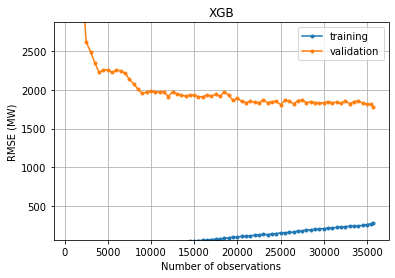

In [5]:
# apply function plot_learning_curves
plot_learning_curves(xgb_steps, xgb_train_mse, xgb_val_mse, title="XGB")

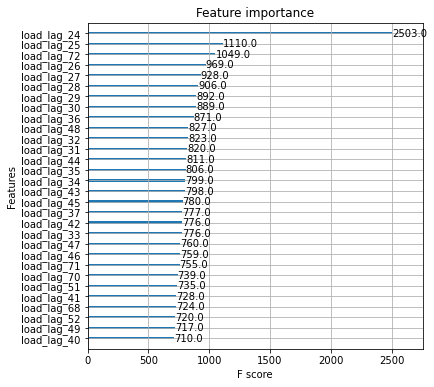

In [6]:
# training model
xgb_model.fit(X_train_prep, y=y_train)

# extract high importance features
_, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_importance(xgb_model, ax=ax, max_num_features=30)

In [11]:
# define grid search algorithm
def xgb_grid_search_cv(
    params_grid, X, y, nfold,
    num_boost_round=1000, early_stopping_rounds=10,
):
    params_grid = ParameterGrid(params_grid)
    search_results = []
    print(f"Grid search CV : nfold={nfold}, " +
          f"numb_boost_round={num_boost_round}, " +
          f"early_stopping_round={early_stopping_rounds}")
    for params in params_grid:
        print(f"\t{params}")
        cv_df = xgb_cv(
            params=params, dtrain=DMatrix(X, y), nfold=nfold,
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds,
            shuffle=False, metrics={"rmse"},
        )
        cv_results = params.copy()
        cv_results["train-rmse-mean"] = cv_df["train-rmse-mean"].min()
        cv_results["test-rmse-mean"] = cv_df["test-rmse-mean"].min()
        search_results.append(cv_results)
    return pd.DataFrame(search_results)
    

In [12]:
# start oprimization process
params_grid = dict(
    eta = [0.05, 0.1, 0.3],
    max_depth = [2, 4, 6],
    min_child_weight = [5, 1])
xgb_search_scores = xgb_grid_search_cv(
    params_grid, X_train_prep, y_train, nfold=4, early_stopping_rounds=10)

Grid search CV : nfold=4, numb_boost_round=1000, early_stopping_round=10
	{'eta': 0.05, 'max_depth': 2, 'min_child_weight': 5}
	{'eta': 0.05, 'max_depth': 2, 'min_child_weight': 1}
	{'eta': 0.05, 'max_depth': 4, 'min_child_weight': 5}
	{'eta': 0.05, 'max_depth': 4, 'min_child_weight': 1}
	{'eta': 0.05, 'max_depth': 6, 'min_child_weight': 5}
	{'eta': 0.05, 'max_depth': 6, 'min_child_weight': 1}
	{'eta': 0.1, 'max_depth': 2, 'min_child_weight': 5}
	{'eta': 0.1, 'max_depth': 2, 'min_child_weight': 1}
	{'eta': 0.1, 'max_depth': 4, 'min_child_weight': 5}
	{'eta': 0.1, 'max_depth': 4, 'min_child_weight': 1}
	{'eta': 0.1, 'max_depth': 6, 'min_child_weight': 5}
	{'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1}
	{'eta': 0.3, 'max_depth': 2, 'min_child_weight': 5}
	{'eta': 0.3, 'max_depth': 2, 'min_child_weight': 1}
	{'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5}
	{'eta': 0.3, 'max_depth': 4, 'min_child_weight': 1}
	{'eta': 0.3, 'max_depth': 6, 'min_child_weight': 5}
	{'eta': 0.3, 'max_d

In [13]:
# sort value for knowing best values for parameters
xgb_search_scores.sort_values(by="test-rmse-mean")

,eta,max_depth,min_child_weight,train-rmse-mean,test-rmse-mean
4,0.05,6,5,1126.532776,1695.603394
3,0.05,4,1,1253.588501,1698.327209
5,0.05,6,1,1087.492920,1700.976135
2,0.05,4,5,1261.738678,1703.409698
10,0.10,6,5,1087.915009,1705.396332
9,0.10,4,1,1210.192749,1707.531372
11,0.10,6,1,1025.227447,1708.382996
8,0.10,4,5,1332.103027,1722.641937
16,0.30,6,5,1108.309113,1776.875671
15,0.30,4,1,1184.048462,1789.801880


In [14]:
# define model after optimization
final_model = XGBRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=6, min_child_weight=5
)

# training model after optimization
final_model.fit(
    X_train_prep, y_train, early_stopping_rounds=10,
    eval_set=[(X_train_prep, y_train), (X_test_prep, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [23]:
# save model
final_model.save_model("models/xgb_model.json")

In [25]:
# create function to compare betwen actual and predict values
def compute_predictions_df(model, X, y):
    y_pred = model.predict(X)
    df = pd.DataFrame(dict(actual=y, prediction=y_pred), index=X.index)
    df["squared_error"] =  (df["actual"] - df["prediction"])**2
    return df, y_pred

pred_df, y_pred = compute_predictions_df(
    final_model, X_test_prep, y_test
)
pred_df.head()

,actual,prediction,squared_error
time,,,
2019-02-04 00:00:00+00:00,49209.25,49146.140625,3982.793213
2019-02-04 01:00:00+00:00,48879.75,49134.277344,64784.168716
2019-02-04 02:00:00+00:00,48956.25,49315.269531,128895.023819
2019-02-04 03:00:00+00:00,50562.00,50252.437500,95828.941406
2019-02-04 04:00:00+00:00,54505.75,53570.695312,874327.268616


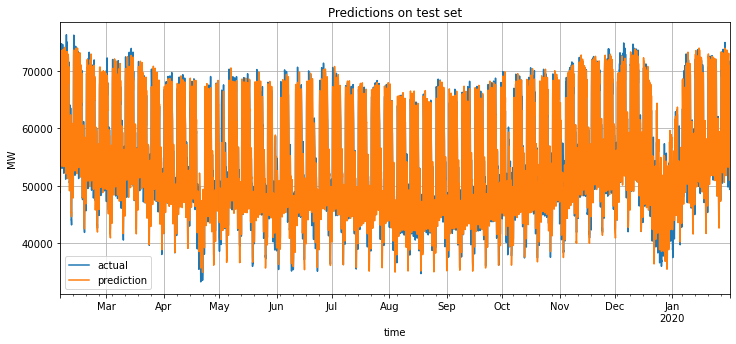

In [26]:
# plotting actual and predict values
def plot_predictions(pred_df, start=None, end=None):
    _, ax = plt.subplots(1, 1, figsize=(12, 5))
    start = start or pred_df.index.min()
    end = end or pred_df.index.max()
    pred_df.loc[
        (pred_df.index >= start) & (pred_df.index <= end),
        ["actual", "prediction"]
    ].plot.line(ax=ax)
    ax.set_title("Predictions on test set")
    ax.set_ylabel("MW")
    ax.grid()

plot_predictions(pred_df)

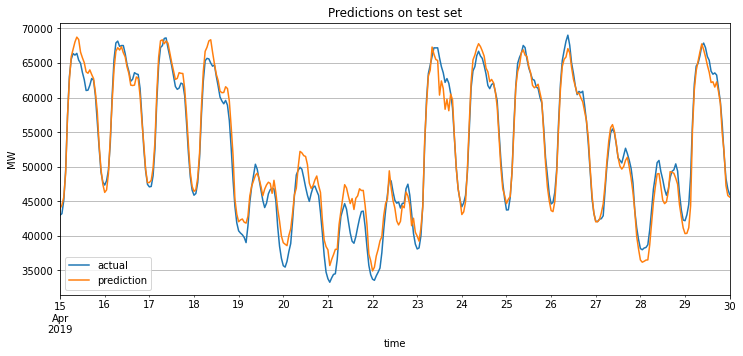

In [27]:
# plotting afew days
plot_predictions(pred_df,
                 start=pd.Timestamp("2019-04-15", tz="utc"),
                 end=pd.Timestamp("2019-04-30", tz="utc"))

In [28]:
# grouping data by Day
daily_pred_df = pred_df.groupby(pd.Grouper(freq="D")).mean()
daily_pred_df.sort_values(by="squared_error", ascending=False).head(5)

,actual,prediction,squared_error
time,,,
2019-06-20 00:00:00+00:00,49399.843750,58144.417969,9.506534e+07
2019-05-02 00:00:00+00:00,57558.822917,49878.003906,7.406463e+07
2019-12-31 00:00:00+00:00,46872.166667,52636.082031,3.842439e+07
2019-12-24 00:00:00+00:00,46353.697917,51739.371094,3.274407e+07
2019-11-01 00:00:00+00:00,51479.760417,56475.671875,3.084658e+07


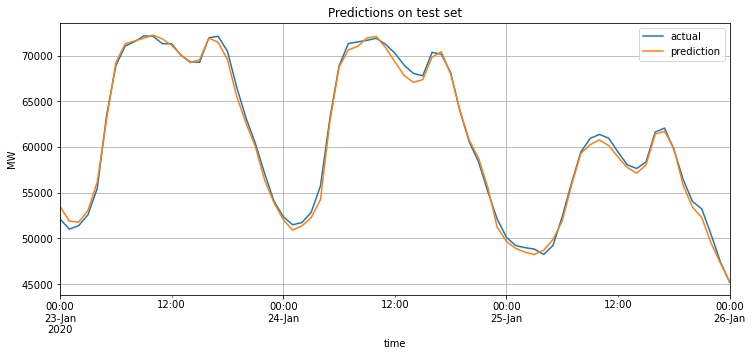

In [29]:
# plotting three days
plot_predictions(pred_df,
                 start=pd.Timestamp("2020-01-23", tz="utc"),
                 end=pd.Timestamp("2020-01-26", tz="utc"))

In [34]:
# apply minmaxscaler method on training output and testing output
y_test = np.array(y_test).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
y_test = scaler.fit_transform(y_test)
y_pred = scaler.fit_transform(y_pred)

In [36]:
# evaluate model
# calculate errors and show them
mse=mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
print('mse', mse)
print('mae', mae)


mse 0.0022174118909183147
mae 0.03475536694877395
